In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding,Flatten,SimpleRNN
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)

In [3]:
path = "Dataset/AAl_G_Weather_SkewFix_19des-22mar.csv"

df_data = pd.read_csv(path)

In [4]:
df_data['Weekday'] = pd.to_datetime(df_data['Recorded']).dt.weekday
df_data['Hour'] = pd.to_datetime(df_data['Recorded']).dt.hour
df_data['Month'] = pd.to_datetime(df_data['Recorded']).dt.month
df_data['Day'] = pd.to_datetime(df_data['Recorded']).dt.day

In [5]:
df_data = df_data.drop(columns=["wdir_cardinal","Recorded","SO2","CO",'heat_index', 'rh', 'pressure', 'wdir', 'wspd', 'Weekday',
       'Hour', 'Month', 'Day'])

In [6]:
#df_data = df_data.drop(columns=["wdir_cardinal","Recorded","SO2","CO"])

KeyError: "['wdir_cardinal', 'Recorded', 'SO2', 'CO'] not found in axis"

In [7]:
df_data.columns

Index(['NO2', 'NOx'], dtype='object')

In [8]:
train_Df = df_data[0:35520]
train_Data = train_Df[0:28416]
val_df = train_Df[28416:]

In [9]:
X_train = train_Data[0:-1].copy()
Y_train = train_Data[["NO2","NOx"]].copy()
Y_train = Y_train[1:]

In [10]:
X_val = val_df[0:-1].copy()
Y_val = val_df[["NO2","NOx"]].copy()
Y_val = Y_val[1:]

In [11]:
Xscaler = StandardScaler()
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = StandardScaler()
Yscaler.fit(Y_train)
scaled_y_train = Yscaler.transform(Y_train)

In [12]:
X_val_scaler = StandardScaler() # scale so that all the X data will range from 0 to 1
X_val_scaler.fit(X_val)
scaled_X_val = X_val_scaler.transform(X_val)
Y_val_scaler = StandardScaler()
Y_val_scaler.fit(Y_val)
scaled_y_val = Y_val_scaler.transform(Y_val)

In [13]:
n_input = 48 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 256 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
valgenerator = TimeseriesGenerator(scaled_X_val,scaled_y_val,length=n_input, batch_size=b_size)

In [14]:
model = Sequential()
#model.add(Embedding(input_dim=48,output_dim=48))
model.add(LSTM(64,activation='tanh', input_shape=(n_input, n_features)))#return_sequences=True))???will raise dimenson error
model.add(Dropout(0.5))
model.add(Dense(2))
#model.add(tf.keras.layers.Reshape([48, 3]))
model.compile(loss='mae',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17152     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1000
111/111 - 6s - loss: 0.4871 - val_loss: 0.4222 - 6s/epoch - 56ms/step
Epoch 2/1000
111/111 - 5s - loss: 0.3889 - val_loss: 0.3772 - 5s/epoch - 43ms/step
Epoch 3/1000
111/111 - 5s - loss: 0.3640 - val_loss: 0.3590 - 5s/epoch - 44ms/step
Epoch 4/1000
111/111 - 5s - loss: 0.3530 - val_loss: 0.3522 - 5s/epoch - 44ms/step
Epoch 5/1000
111/111 - 5s - loss: 0.3461 - val_loss: 0.3443 - 5s/epoch - 45ms/step
Epoch 6/1000
111/111 - 5s - loss: 0.3418 - val_loss: 0.3404 - 5s/epoch - 45ms/step
Epoch 7/1000
111/111 - 5s - loss: 0.3376 - val_loss: 0.3320 - 5s/epoch - 43ms/step
Epoch 8/1000
111/111 - 5s - loss: 0.3353 - val_loss: 0.3316 - 5s/epoch - 44ms/step
Epoch 9/1000
111/111 - 5s - loss: 0.3332 - val_loss: 0.3297 - 5s/epoch - 45ms/step
Epoch 10/1000
111/111 - 5s - loss: 0.3300 - val_loss: 0.3291 - 5s/epoch - 44ms/step
Epoch 11/1000
111/111 - 5s - loss: 0.3289 - val_loss: 0.3267 - 5s/epoch - 45ms/step
Epoch 12/1000
111/111 - 5s - loss: 0.3277 - val_loss: 0.3237 - 5s/epoch - 47ms/step
E

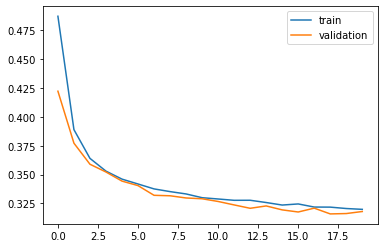

In [15]:
#model.fit(generator,epochs=5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
history = model.fit(generator, epochs=1000, shuffle=False,
                        validation_data=(valgenerator),
                        callbacks=[early_stopping],
                        verbose=2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
#loss: 0.0697 - val_loss: 0.0705

In [ ]:
prediction_scale = model.predict(valgenerator)
prediction = Y_val_scaler.inverse_transform(prediction_scale)
score = get_score(prediction,Y_val[48:].values)
score_scale = get_score(prediction_scale,scaled_y_val[48:])
print("val_loss Scaled:",score_scale)
print("val_loss normal:",score)
#val_loss Scaled: 0.0704687674215029
#val_loss normal: 8.073557116709654

# only no2 and nox
# val_loss Scaled: 0.06653629638204941
# val_loss normal: 7.746880428846217

# only nox
# val_loss Scaled: 0.0531022798611278
# val_loss normal: 11.29113777435637

#all feature standscaler
# val_loss Scaled: 0.3245211855305854
# val_loss normal: 7.108827759272458

# only no2 and nox stand
# val_loss Scaled: 0.3431033484705448
# val_loss normal: 7.522633463630418

val_loss Scaled: 0.3431033484705448
val_loss normal: 7.522633463630418


 Computing LSTM Feature importance...



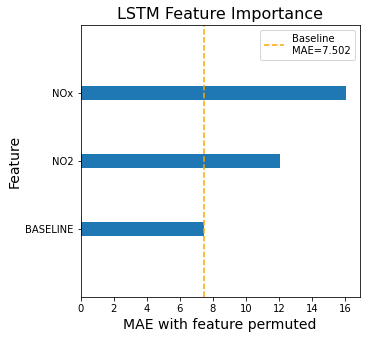

In [ ]:
columnsTitles=train_Data.columns.to_list()
results = []
print(' Computing LSTM Feature importance...')
feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
baseline_mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
results.append({'feature': 'BASELINE', 'mae': baseline_mae})

for i in range(len(columnsTitles)):
    save_col = scaled_X_val[:,i].copy()
    np.random.shuffle(scaled_X_val[:,i])
    feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
    feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
    mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
    results.append({'feature': columnsTitles[i], 'mae': mae})
    
    scaled_X_val[:,i] = save_col

print()
width = [0.2]
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(5,5))
plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(columnsTitles)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                    label=f'Baseline \nMAE={baseline_mae:.3f}')
plt.xlabel('MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [ ]:
test_df = df_data[35520: -6]
X_test = test_df.copy()
scaled_X_test = Xscaler.transform(X_test)
nplen = (X_test.shape[0],3)
npzeros = np.zeros(nplen)

In [ ]:
test_generator = TimeseriesGenerator(scaled_X_test, npzeros, length=n_input, batch_size=b_size)

In [ ]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [ ]:
NO2_pred = [i[0] for i in y_pred]
NOx_pred = [i[1] for i in y_pred]

In [ ]:
predictionsDf = pd.DataFrame({"Pred_NO2":NO2_pred,"Pred_NOx":NOx_pred})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LSTM/AAl_G_Prediction.csv",index=False)

In [ ]:
NO2_real =test_df["NO2"].values
NOx_real =test_df["NOx"].values

In [ ]:
realDF = pd.DataFrame({"Real_NO2":NO2_real,"Real_NOx":NOx_real})
realDF.to_csv("LSTM/AAl_G_Real.csv",index=False)

In [ ]:
score = get_score(NO2_real[48:],NO2_pred)
score
#1.963623620451355 relu linear
#1.7938049322538414 tanh tanh

4.160626303255338

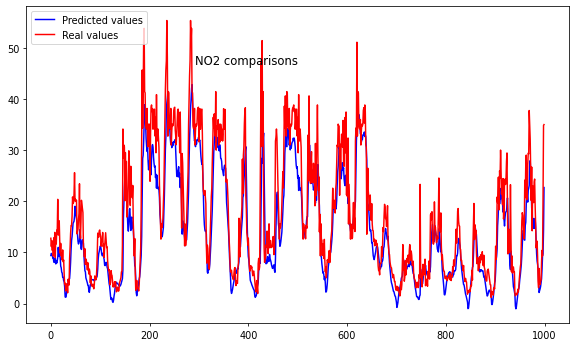

In [ ]:

plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NO2_pred[0:1000], "-b", label="Predicted values")
plt.plot(NO2_real[48:1048], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()